# 实验环境
Python 3.10.6
PyTorch 1.13.0
Matplotlib 3.7.1

# 导入必要的库

In [22]:
import os

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision import models

import matplotlib.pyplot as plt
from PIL import Image

# 设置信息

In [23]:
device = (
    torch.device(device="cuda")
    if torch.cuda.is_available()
    else torch.device(device="cpu")
)
print("Device: {}".format(device))

config = {
    "training_path": os.path.join("dataset", "training"),
    "test_path": os.path.join("dataset", "test"),
    "weights_path": "model_weights.pth",
    "optimizer_path": "optimizer_state.pth",
    "data_size": 3616,
    "HEIGHT": 224,
    "WIDTH": 224,
    "_R_MEAN": 123.68,
    "_G_MEAN": 116.78,
    "_B_MEAN": 103.94,
    "_R_STD": 1,
    "_G_STD": 1,
    "_B_STD": 1,
    "_RESIZE_SIDE_MIN": 256,
    "_RESIZE_SIDE_MAX": 512,
    "batch_size": 32,
    "num_class": 5,
    "epoch_size": 150,
    "loss_scale_num": 1024,
    "prefix": "resent-ai",
    "directory": "model_resnet",
    "save_checkpoint_steps": 10,
}

lr = 5e-4

Device: cuda


# 定义训练数据集和测试数据集并预处理

In [24]:
training_transform = transforms.Compose(
    transforms=[
        transforms.RandomResizedCrop(
            size=(config["HEIGHT"], config["WIDTH"]),
            scale=(0.5, 1.0),
            ratio=(1.0, 1.0),
        ),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)


test_transform = transforms.Compose(
    transforms=[
        transforms.Resize(size=(config["_RESIZE_SIDE_MIN"])),
        transforms.CenterCrop(size=(config["HEIGHT"], config["WIDTH"])),
        transforms.ToTensor(),
    ]
)


training_data = datasets.ImageFolder(
    root=config["training_path"],
    transform=training_transform,
)


test_data = datasets.ImageFolder(
    root=config["test_path"],
    transform=test_transform,
)


training_loader = DataLoader(
    dataset=training_data,
    batch_size=config["batch_size"],
    shuffle=True,
    drop_last=True,
)


test_loader = DataLoader(
    dataset=test_data,
    batch_size=1,
)

# 打印部分信息

Training set size: 2935
Test set size: 738
Channel size, height, width: torch.Size([3, 224, 224])
Label of the first photo: 1


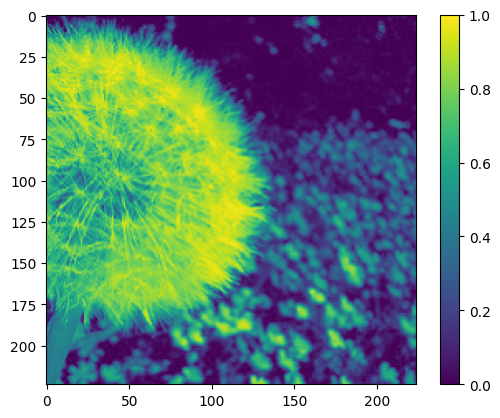

In [25]:
print("Training set size: {}".format(len(training_data)))
print("Test set size: {}".format(len(test_data)))

classes = test_data.classes
training_features, training_labels = next(iter(training_loader))
print("Channel size, height, width: {}".format(training_features[0].shape))
print("Label of the first photo: {}".format(training_labels[0]))

plt.figure()
plt.imshow(training_features[0, 0, ...])
plt.colorbar()
plt.grid(visible=False)
plt.show()

# 定义神经网络模型、损失函数和优化器

In [26]:
model = models.resnet50()
model.fc = nn.Linear(in_features=2048, out_features=5)
model.to(device=device)
model.load_state_dict(torch.load(f=config["weights_path"]))
model.eval()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    params=model.parameters(),
    lr=lr,
    momentum=0.9,
    weight_decay=1e-4,
)
optimizer.load_state_dict(state_dict=torch.load(f=config["optimizer_path"]))

# 训练神经网络模型并测试结果
由于已经预训练过模型的参数，这里仅打印对测试图像的分类结果。

In [27]:
def train_loop(dataloader, model, loss_fn, optimizer):
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)

            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print("Accuracy: {}, Avg loss: {}\n".format(correct, test_loss))

"""
epoch = 10
for _ in range(epoch):
    train_loop(dataloader=training_loader, model=model, loss_fn=loss_fn, optimizer=optimizer)
torch.save(obj=model.state_dict(), f=config["weights_path"])
torch.save(obj=optimizer.state_dict(), f=config["optimizer_path"])
"""

test_loop(dataloader=test_loader, model=model, loss_fn=loss_fn)

Accuracy: 0.7615176151761518, Avg loss: 0.6396574971251213



# 绘制误差图像
在前 100 轮训练过程中记录了训练误差和测试误差。

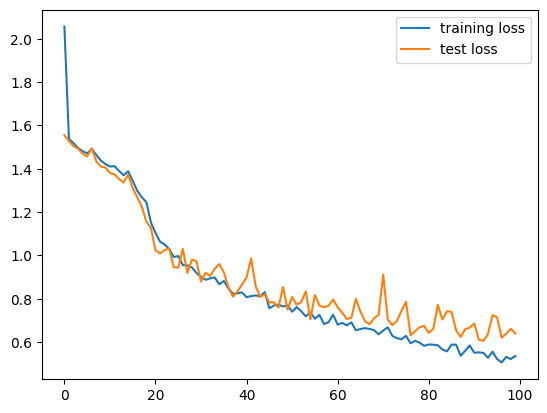

In [28]:
with open(file="training_loss.txt", mode="r") as f:
    training_loss = [float(loss) for loss in f.readlines()]

with open(file="test_loss.txt", mode="r") as f:
    test_loss = [float(loss) for loss in f.readlines()]

plt.plot(training_loss, label="training loss")
plt.plot(test_loss, label="test loss")
plt.legend()
plt.show()

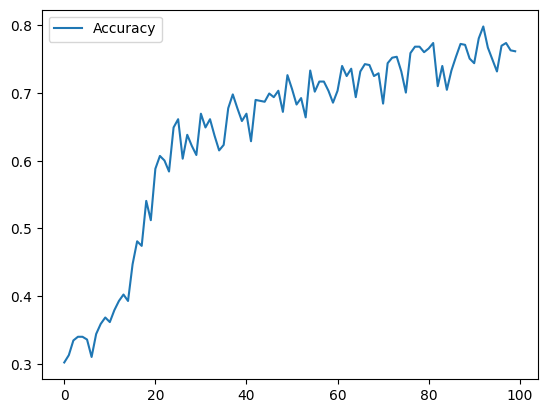

In [29]:
with open(file="accuracy.txt", mode="r") as f:
    accuracy = [float(acc) for acc in f.readlines()]

plt.plot(accuracy, label="Accuracy")
plt.legend()
plt.show()

# 测试三张图片的分类

In [30]:

class_map = training_data.classes

rose = Image.open(
    fp=os.path.join("dataset", "test", "roses", "rose.jpg")
)
sunflower = Image.open(
    fp=os.path.join("dataset", "test", "sunflowers", "sunflower.jpg")
)
tulips = Image.open(
    fp=os.path.join("dataset", "test", "tulips", "tulips.jpg")
)

rose = test_transform(rose)
sunflower = test_transform(sunflower)
tulips = test_transform(tulips)

rose = torch.unsqueeze(input=rose, dim=0)
sunflower = torch.unsqueeze(input=sunflower, dim=0)
tulips = torch.unsqueeze(input=tulips, dim=0)

rose = rose.to(device=device)
sunflower = sunflower.to(device=device)
tulips = tulips.to(device=device)

pred = model(rose)
print("Prediction of rose.jpg:")
print(
    "Scores:\n{},\nprediction: {},\npredicted label: {}\n".format(
        pred.data, torch.argmax(pred.data), class_map[torch.argmax(pred.data)]
    )
)

pred = model(sunflower)
print("Prediction of sunflower.jpg:")
print(
    "Scores:\n{},\nprediction: {},\npredicted label: {}\n".format(
        pred.data, torch.argmax(pred.data), class_map[torch.argmax(pred.data)]
    )
)

pred = model(tulips)
print("Prediction of tulips.jpg:")
print(
    "Scores:\n{},\nprediction: {},\npredicted label: {}\n".format(
        pred.data, torch.argmax(pred.data), class_map[torch.argmax(pred.data)]
    )
)

Prediction of rose.jpg:
Scores:
tensor([[-2.3598, -4.6731,  6.7207, -4.8642,  4.8836]], device='cuda:0'),
prediction: 2,
predicted label: roses

Prediction of sunflower.jpg:
Scores:
tensor([[-4.1373, -3.3282, -3.1920, 12.5895, -2.1965]], device='cuda:0'),
prediction:3,
predicted label: sunflowers

Prediction of tulips.jpg:
Scores:
tensor([[-2.4236, -6.9851,  4.3386, -3.8036,  8.8189]], device='cuda:0'),
prediction: 4,
predicted label: tulips

